In [7]:
import sympy as sp
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve
from IPython.display import display
from joblib import Parallel, delayed
sp.init_printing()

print(scipy.__version__)
print(sp.__version__)


1.15.1
1.13.3


In [1]:
def model_simulator(y, t, model_dictionary):
    for time, cur_model in model_dictionary.items():
        if time[0] <= t < time[1]:
            return cur_model["model"](*y).flatten()


def model_fixed_point_function(ic, model_function):
    return model_function(*ic).flatten()


def simulate_HPA(ic, variables, sim_time, model_dictionary):
    result = odeint(model_simulator, ic, sim_time, args=(model_dictionary,), hmax=0.01)
    result_df = pd.DataFrame(result, columns=variables)
    return result_df


def run_simulation(ic, variables, model, sim_time, parameters_low, parameters_high, high_time_list=[(0, 0)]):
    model_dict = {}
    model_high_function = sp.lambdify(variables, model.subs(parameters_high))
    model_low_function = sp.lambdify(variables, model.subs(parameters_low))
    for high_time_interval in high_time_list:
        model_dict[high_time_interval] = {"model": model_high_function}
    model_dict[-np.inf, np.inf] = {"model": model_low_function}
    res_df = simulate_HPA(ic, sim_time, model_dict, variables)
    res_df.index = sim_time
    return res_df

In [21]:
def sde_solver_system(drift, x0, t, sigma, params):
    n = len(t)
    d = len(x0)
    x = np.zeros((n, d))
    x[0] = x0
    dt = t[1] - t[0]
    for i in range(1, n):
        dw = np.random.normal(scale= np.sqrt(dt))
        x[i] = x[i - 1] + drift(x[i - 1], t[i - 1], *params) * dt + sigma * dw 
    return x

def one_d_model_drift(x, t, b, u):
    dx1 = x**2 * (1-x) - b * x + u
    return dx1


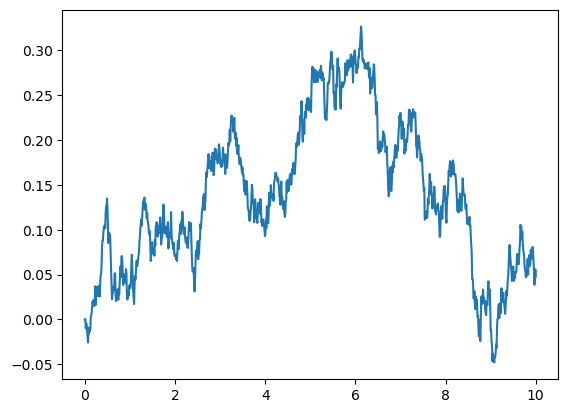

In [29]:
T = 10
n_points = 1000
t = np.linspace(0, T, n_points)
x0 = [0]
sigma = 0.1
parms = (0.2,0)
sol = sde_solver_system(one_d_model_drift, x0, t , sigma, parms)
plt.plot(t, sol)

In [28]:
params = (0.2,0)
def f_to_solve(x):
    return one_d_model_drift(x, 0, *params)


guess = [1]
steady_state = fsolve(f_to_solve, guess)
x0 = steady_state
print(x0)

[0.7236068]
